In [9]:
import numpy as np
import matplotlib.pylab as plt
import librosa
import scipy
import scipy.io.wavfile as wavfile
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy import signal

# This function play the sound by given data (x)
def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    display( HTML( 
    '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
    '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
    ))

# This function load sound file from local
def wavreadlocal(filename):
    import urllib.request, io, scipy.io.wavfile
    # f = wave.open(filename,"rb")
    sr,s = scipy.io.wavfile.read(filename)
    return sr, s.astype( 'float32')/32768

# This function can plot a time series 
def fre_axis(sr_sound,x_sound,title):
    fig, ax = plt.subplots(1,1)
    ax.plot(np.linspace(0,np.shape(x_sound)[0],np.shape(x_sound)[0]), x_sound)
    ax.set_title(title)

# This function can plot a time series 
def fre_2axis(sr_sound,x_sound,title):
    fig, ax = plt.subplots(1,1)
    c_list = [1,2]
    for data in x_sound:
        ax.plot(np.linspace(0,np.shape(data)[0],np.shape(data)[0]), data)
    ax.legend([f'channel {c}' for c in c_list],
                loc='lower left', ncol=len(c_list))
    ax.set_title(title)

# This function create a average filter
def window(size):
    return np.ones(size)/float(size)

# This funciton perform a convolution using average filter recursively 
def smooth_filter(x_input, count):
    if count <= 0:
        return np.convolve(abs(x_input),window(10000),'same')
    else:
        return np.convolve(smooth_filter(x_input,count-1),window(1000),'same')
    
def stft_axis(sr_sound, x_sound, stft_sound, title):
    time_axis = np.linspace(0, len(x_sound) / sr_sound, num=np.shape(stft_sound)[0] + 1)
    freq_axis = np.fft.rfftfreq(np.shape(stft_sound)[1], 1 / sr_sound)
    fig, ax = plt.subplots(1,1)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(title)
    ax.imshow(abs(np.power(stft_sound.T, 0.3)), origin="lower", aspect='auto', extent=[time_axis[0], time_axis[-1], freq_axis[0], freq_axis[-1]])

In [4]:
y_keys = []
x_keys = []
# we have 4 temporary recorded sound files for testing
file_num = 4
for i in range(0,file_num):
    sr_key, x_key = wavreadlocal(f'keystroke{i}.wav')
    print(x_key.shape)
    x_key = x_key.T[0].T[:94000]
    y_key = np.random.choice(['a','s','d'], 1)
    x_keys.append(x_key)
    y_keys.append(y_key[0])

y_keys = np.array(y_keys)
x_keys = np.array(x_keys)
print(f"shape of x_keys:{x_keys.shape}")
print(f"shape of y_keys:{y_keys.shape}")

(98400, 2)
(94080, 2)
(105120, 2)
(123360, 2)
shape of x_keys:(4, 94000)
shape of y_keys:(4,)


## Stage 1. Capture the keystroke sound

Task 1: locate the keystroke in an audio clip

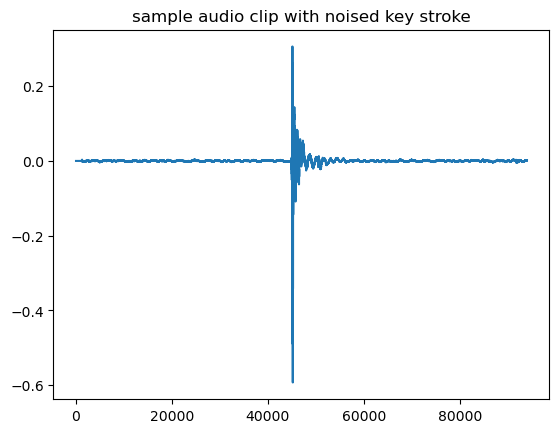

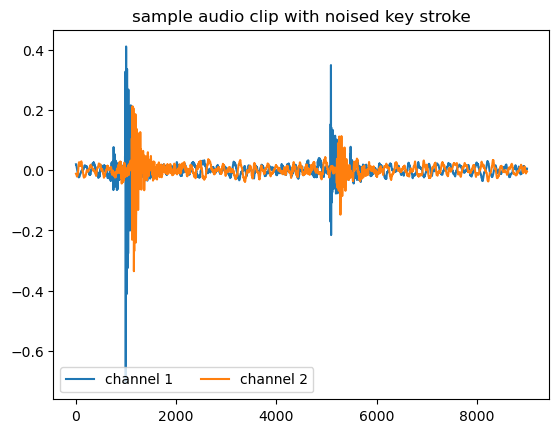

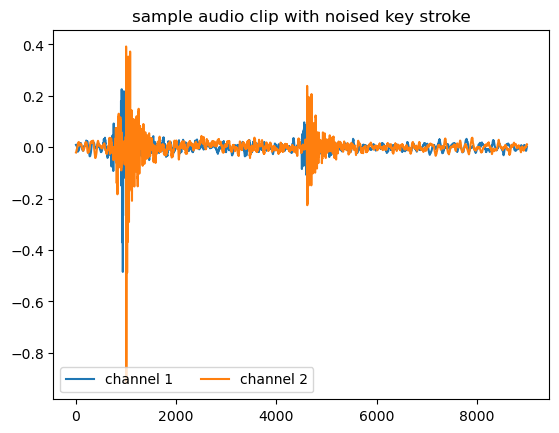

In [10]:
data4 = np.load('../data/kb1_noise4_1100ms.npz')

def stft( input_sound, dft_size, hop_size, zero_pad, window):
    dft_sound = np.lib.stride_tricks.sliding_window_view(input_sound, dft_size)[::hop_size, :]

    dft_sound = window*dft_sound

    if zero_pad:
        dft_sound = np.fft.rfft(dft_sound,dft_size+zero_pad)
    else:
        dft_sound = np.fft.rfft(dft_sound)
    
    return dft_sound

# s_i: the index of sound file to test
# 0: single keystroke with noise.   1,2: single keystroke with tiny noise.  3: double keystroke with tiny noise
s_i = 1
fre_axis(sr_key,x_keys[s_i],'sample audio clip with noised key stroke')

# stft step
dft_size = 256
hop_size = int(1/4 * dft_size)
zero_pad = dft_size
window = np.hamming(dft_size)
epsilon = 1e-7

data4_x = data4['x'][67].T
data4_x2 = data4['x'][128].T
# print(data4_x.shape)
fre_2axis(sr_key,data4_x,'sample audio clip with noised key stroke')
fre_2axis(sr_key,data4_x2,'sample audio clip with noised key stroke')
# stft_si = stft( data4_x, dft_size, hop_size, zero_pad, window)
# stft_axis(sr_key, data4_x, stft_si, 'stft_test')


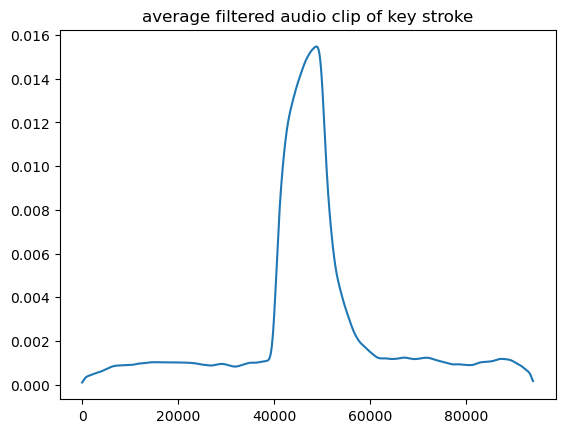

In [9]:
fre_axis(sr_key,smooth_filter(x_keys[s_i],4),'average filtered audio clip of key stroke')


In [91]:
import numpy as np
import os
import matplotlib.pylab as plt
import librosa
import scipy.io.wavfile as wavfile
from scipy import signal


'''
This file build the denoise model by taking .npz form file of sound data. The denoise model will be saved in /denoise_model
'''

filepath = "../data/kb1_noise0.5_1100ms.npz"



def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    display( HTML( 
    '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
    '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
    ))

def wavreadlocal(filename):
    import urllib.request, io, scipy.io.wavfile
    # f = wave.open(filename,"rb")
    sr,s = scipy.io.wavfile.read(filename)
    return sr, s.astype( 'float32')/32768

def stft( input_sound, dft_size, hop_size, zero_pad, window):
    dft_sound = np.lib.stride_tricks.sliding_window_view(input_sound, dft_size)[::hop_size, :]

    dft_sound = window*dft_sound

    if zero_pad:
        dft_sound = np.fft.rfft(dft_sound,dft_size+zero_pad)
    else:
        dft_sound = np.fft.rfft(dft_sound)
    
    return dft_sound

def overlap_add(idft_sound, hop_size, window):
    n_frames, frame_len = idft_sound.shape
    total_len = (n_frames - 1) * hop_size + frame_len
    result = np.zeros(total_len)

    for i, frame in enumerate(idft_sound):
        start = i * hop_size
        end = start + frame_len
        result[start:end] += frame * window

    return result

def istft(stft_output, dft_size, hop_size, zero_pad, window):
    idft_sound = np.fft.irfft(stft_output)
    idft_sound_without_padding = idft_sound[:, :dft_size]
    idft_sound_windowed = idft_sound_without_padding * window
    resynthesized_signal = overlap_add(idft_sound_windowed, hop_size, window)
    return resynthesized_signal


def stft_axis(sr_sound, x_sound, stft_sound, title):
    time_axis = np.linspace(0, len(x_sound) / sr_sound, num=np.shape(stft_sound)[0] + 1)
    freq_axis = np.fft.rfftfreq(np.shape(stft_sound)[1], 1 / sr_sound)
    fig, ax = plt.subplots(1,1)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(title)
    ax.imshow(abs(np.power(stft_sound.T, 0.3)), origin="lower", aspect='auto', extent=[time_axis[0], time_axis[-1], freq_axis[0], freq_axis[-1]])

def fre_axis(sr_sound,x_sound,title):
    fig, ax = plt.subplots(1,1)
    ax.plot(np.linspace(0,np.shape(x_sound)[0],np.shape(x_sound)[0]), x_sound)
    ax.set_title(title)

# function to train the w and h based on given stft data
def standard_train(x_stft,k):
    # initialize f, w ,and h matrices
    epsilon = 1e-7
    rng = np.random.default_rng()
    f = np.abs(x_stft).T
    m,n = np.shape(f)
    w = rng.random((m,k))+10
    h = rng.random((k,n))+10

    # iterate the learning process
    iter_num = 300
    for i in range(iter_num):
        v = f/(np.dot(w,h)+epsilon)
        h = h*np.dot(w.T,v)
        w = w*np.dot(v,h.T)
        w = w / np.sum(w, axis=0)
        if i%2 == 0:
            print(f"round {i}/{iter_num}")
    return w,h

def standard_train2(x_stft, k, threshold=1e-4, max_iter=300):
    """
    Function to train the w and h matrices based on given stft data with convergence check.

    Parameters:
    x_stft (numpy.ndarray): Input STFT data.
    k (int): Number of components.
    threshold (float): Convergence threshold for the reconstruction error change.
    max_iter (int): Maximum number of iterations.

    Returns:
    numpy.ndarray: Trained w matrix.
    numpy.ndarray: Trained h matrix.
    """
    epsilon = 1e-7
    rng = np.random.default_rng()
    f = np.abs(x_stft).T
    m, n = np.shape(f)
    w = rng.random((m, k)) + 10
    h = rng.random((k, n)) + 10

    prev_error = float('inf')

    for i in range(max_iter):
        # NMF update rules
        v = f / (np.dot(w, h) + epsilon)
        h = h * np.dot(w.T, v)
        w = w * np.dot(v, h.T)
        w = w / np.sum(w, axis=0)

        # Calculate reconstruction error
        reconstruction = np.dot(w, h)
        error = np.linalg.norm(f - reconstruction, 'fro')  # Frobenius norm

        # Check for convergence
        if abs(prev_error - error) < threshold:
            print(f"Convergence achieved at iteration {i+1} with error {error}")
            break

        prev_error = error

        if i % 2 == 0:
            print(f"Round {i+1}/{max_iter}, Reconstruction Error: {error}")

    return w, h


def build_denoise(filepath):


    if not os.path.exists("denoise_model/"):
        os.makedirs("denoise_model/")

    data_x = np.load(filepath)['x']
    print(f"data_x.shape:{data_x.shape}")
    shape = data_x.shape
    data_x = data_x.reshape(shape[0]*shape[2],shape[1])
    print(f"data_x.shape:{data_x.shape}")

    # stft step
    dft_size = 256
    hop_size = int(2/4 * dft_size)
    zero_pad = dft_size
    window = np.hamming(dft_size)
    temp_list = []
    for data in data_x:
        temp_list.append(stft(data, dft_size, hop_size, zero_pad, window)) 

    stft_data = np.array(temp_list)
    print(f"stft_data.shape:{stft_data.shape}")

    x_shape = data_x.shape
    data_x = data_x.reshape(x_shape[0]*x_shape[1])
    stft_shape = stft_data.shape
    stft_data = stft_data.reshape(stft_shape[0]*stft_shape[1], stft_shape[2])
    stft_phase = np.exp(1j * np.angle(stft_data))

    # stft_axis(44100, data_x, stft_data, "random stft_img")
    # istft_rand_data = istft(stft_data, dft_size, hop_size, zero_pad, window)
    # sound( data_x, rate=44100, label='')
    # sound( istft_rand_data, rate=44100, label='')


    # rand_index = np.random.randint(low = 0, high = stft_data.shape[0]-1, size = 1)[0]
    # print(rand_index)
    # stft_axis(44100, data_x[rand_index], stft_data[rand_index], "random stft_img")
    # istft_rand_data = istft(stft_data[rand_index], dft_size, hop_size, zero_pad, window)

    # def pad_sound(x):
    #     return np.pad(x, (20000, 20000), 'constant', constant_values=(0))
    
    # sound( pad_sound(data_x[rand_index]), rate=44100, label='')
    # sound( pad_sound(istft_rand_data), rate=44100, label='')
    
    plt.show()

    k = 60
    w_data,h_data = standard_train2(stft_data,k)

    # reconstruct_stft = np.dot(w_data, h_data) * stft_phase.T
    # print(f"reconstruct_stft.shape:{reconstruct_stft.shape}")
    # reconstruct_istft = istft(reconstruct_stft.T, dft_size, hop_size, zero_pad, window)
    # sound(reconstruct_istft, rate = 44100, label='reconstruct sound')

    file_list = filepath.split("/")
    # np.savez(f"denoise_model/w_{file_list[-1]}", x=w_data)


    return 0


build_denoise(filepath)

data_x.shape:(533, 9000, 2)
data_x.shape:(1066, 9000)
stft_data.shape:(1066, 69, 257)
Round 1/300, Reconstruction Error: 786.2612904076577
Round 3/300, Reconstruction Error: 864.728626986363
Round 5/300, Reconstruction Error: 864.5800888146849
Round 7/300, Reconstruction Error: 863.8203776616841
Round 9/300, Reconstruction Error: 859.7884994176751
Round 11/300, Reconstruction Error: 839.4013085382437


KeyboardInterrupt: 

In [89]:
import numpy as np
import os
import matplotlib.pylab as plt
import librosa
import scipy.io.wavfile as wavfile
from scipy import signal


'''
This file take w (frequency factor) matrix to perform denoise on given file or directory of file
'''

w_filepath = "../denoise_model/w_kb1_noise0.5_1100ms.npz"
data_filepath = "../records/kb1_noise4_1100ms/"


def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    display( HTML( 
    '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
    '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
    ))

def wavreadlocal(filename):
    import urllib.request, io, scipy.io.wavfile
    # f = wave.open(filename,"rb")
    sr,s = scipy.io.wavfile.read(filename)
    return sr, s.astype( 'float32')/32768

def stft( input_sound, dft_size, hop_size, zero_pad, window):
    dft_sound = np.lib.stride_tricks.sliding_window_view(input_sound, dft_size)[::hop_size, :]

    dft_sound = window*dft_sound

    if zero_pad:
        dft_sound = np.fft.rfft(dft_sound,dft_size+zero_pad)
    else:
        dft_sound = np.fft.rfft(dft_sound)
    
    return dft_sound

def overlap_add(idft_sound, hop_size, window):
    n_frames, frame_len = idft_sound.shape
    total_len = (n_frames - 1) * hop_size + frame_len
    result = np.zeros(total_len)

    for i, frame in enumerate(idft_sound):
        start = i * hop_size
        end = start + frame_len
        result[start:end] += frame * window

    return result

def istft(stft_output, dft_size, hop_size, zero_pad, window):
    idft_sound = np.fft.irfft(stft_output)
    idft_sound_without_padding = idft_sound[:, :dft_size]
    idft_sound_windowed = idft_sound_without_padding * window
    resynthesized_signal = overlap_add(idft_sound_windowed, hop_size, window)
    return resynthesized_signal


def stft_axis(sr_sound, x_sound, stft_sound, title):
    time_axis = np.linspace(0, len(x_sound) / sr_sound, num=np.shape(stft_sound)[0] + 1)
    freq_axis = np.fft.rfftfreq(np.shape(stft_sound)[1], 1 / sr_sound)
    fig, ax = plt.subplots(1,1)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(title)
    ax.imshow(abs(np.power(stft_sound.T, 0.3)), origin="lower", aspect='auto', extent=[time_axis[0], time_axis[-1], freq_axis[0], freq_axis[-1]])

def fre_axis(sr_sound,x_sound,title):
    fig, ax = plt.subplots(1,1)
    ax.plot(np.linspace(0,np.shape(x_sound)[0],np.shape(x_sound)[0]), x_sound)
    ax.set_title(title)

def fre_2axis(sr_sound,x_sound,title):
    fig, ax = plt.subplots(1,1)
    for line in x_sound:
        ax.plot(np.linspace(0,np.shape(line)[0],np.shape(line)[0]), line)
    ax.set_title(title)

# This function can use numpy array to write a wav file to loacl
def wavwritelocal(filename, sr, data):
    # Assuming data is in the range -1 to 1, denormalize to -32768 to 32767
    int_data = np.int16(data * 32767)

    # Write to WAV file
    wavfile.write(filename, sr, int_data)

# function to train the w and h based on given stft data
def standard_train(x_stft,k):
    # initialize f, w ,and h matrices
    epsilon = 1e-7
    rng = np.random.default_rng()
    f = np.abs(x_stft).T
    m,n = np.shape(f)
    w = rng.random((m,k))+10
    h = rng.random((k,n))+10

    # iterate the learning process
    iter_num = 100
    for i in range(iter_num):
        reconstruction = np.dot(w, h)
        v = f/(reconstruction+epsilon)
        h = h*np.dot(w.T,v)
        w = w*np.dot(v,h.T)
        w = w / np.sum(w, axis=0)

        error = np.linalg.norm(f - reconstruction, 'fro')  # Frobenius norm
        if i%20 == 0:
            print(f"round {i}/{iter_num}. error:{error}")
    return w,h


def denoise_data(w_filepath, data_filepath):

    # stft step
    dft_size = 1024
    hop_size = int(2/4 * dft_size)
    zero_pad = dft_size
    window = np.hamming(dft_size)
    epsilon = 1e-7

    
    w_feature = np.load(w_filepath)['x']
    w_shape = w_feature.shape
    print(f"w_shape:{w_shape}")

    file_list = data_filepath.split("/")

    if not os.path.exists("record_denoised/"):
        os.makedirs("record_denoised/")

    if not os.path.exists(f"record_denoised/{file_list[-2]}/"):
        os.makedirs(f"record_denoised/{file_list[-2]}/")

    rng = np.random.default_rng()

    def find_thre_index(x, div):

        thre = np.max(x)/div

        thre_list_0 = np.argwhere(x[:,0]>thre)
        thre_list_1 = np.argwhere(x[:,1]>thre)

        if len(thre_list_0) <= 0:
            min_0 = float('inf')
        else:
            min_0 = thre_list_0[0]
        if len(thre_list_1) <= 0:
            min_1 = float('inf')
        else:
            min_1 = thre_list_1[0]

        print(f"min_0:{min_0}")
        print(f"min_1:{min_1}")

        thre_index = min(min_0,min_1)[0]

        return thre_index
    
    

    count = 0
    for file in os.listdir(data_filepath):

        sr, x_data = wavreadlocal(data_filepath+file)

        
        print(f"x_data.shape:{x_data.shape}")

        thre_index_key = find_thre_index(x_data,5)

        print(f"thre_index_key:{thre_index_key}")
        
        keystroke_x = x_data[thre_index_key-1000: thre_index_key+8000, :]
        noise_x = np.concatenate((x_data[:thre_index_key-1000, :], x_data[thre_index_key+8000:, :]), axis=0)
        # noise_x = x_data[:thre_index_key-1000, :] + x_data[thre_index_key+8000:, :]

        print(f"keystroke_x.shape:{keystroke_x.shape}")
        print(f"noise_x.shape:{noise_x.shape}")

        x_data = np.array(x_data).T
        noise_x = np.array(noise_x).T

        x_stft_list = []
        noise_stft_list = []

        for channel in x_data:
            x_stft_list.append(stft(input_sound = channel,dft_size = dft_size, hop_size = hop_size, zero_pad = zero_pad, window = window))

        for channel in noise_x:
            noise_stft_list.append(stft(input_sound = channel,dft_size = dft_size, hop_size = hop_size, zero_pad = zero_pad, window = window))

        # compute original phase of the mix sound
        extracted_x_list = []
        extracted_noise_list = []
        reconstuct_list = []

        for i in range(len(x_stft_list)):
            x_stft = x_stft_list[i]
            noise_stft = noise_stft_list[i]

            original_phase = np.exp(1j * np.angle(x_stft))

            k_noise = 40
            # w_noise = rng.random((w_shape[0],k_noise))+10
            w_noise, h_noise = standard_train(noise_stft, 20)
            # print(f"w_feature.shape:{w_feature.shape}")
            # print(f"w_noise.shape:{w_noise.shape}")
            w_mix = np.hstack((w_feature,w_noise))
            print(f"w_mix.shape:{w_mix.shape}")
            f = np.abs(x_stft).T
            m,n = np.shape(f)
            h_mix = rng.random((w_mix.shape[1],n))+10
            print(f"h_mix.shape:{h_mix.shape}")

            # train and learn h matrix with fixed w matrix
            for i in range(100):

                # w_mix = np.hstack((w_feature,w_noise))
                # w_mix = w_mix / np.sum(w_mix, axis=0)
                reconstruction = np.dot(w_mix,h_mix)
                v = f/(reconstruction+epsilon)
                h_mix = h_mix*np.dot(w_mix.T,v)
                # w_mix = w_mix*np.dot(v,h_mix.T)
                # w_mix = w_mix / np.sum(w_mix, axis=0)
                # w_noise = w_mix[:,-k_noise:]

                
                error = np.linalg.norm(f - reconstruction, 'fro')  # Frobenius norm

                # if i % 50 == 0:
                #     print(f"round {i}, error:{error}")

            extracted_stft_x = np.zeros_like(x_stft).T
            extracted_noise_x = np.zeros_like(x_stft).T
            # extract each component of the sound
            # for i in range(w_shape[1]):
            #     index = i
            #     # single_x_stft = np.outer(w_mix.T[index],h_mix[index])*original_phase.T
            #     print(f"np.dot(w_mix.T[:index],h_mix[:index]).shape:{np.dot(w_mix.T[:index,:],h_mix[:index,:]).shape}")
            #     single_x_stft = np.dot(w_mix[:,:index],h_mix[:index,:])*original_phase.T
            #     extracted_stft_x += single_x_stft
            print(f"w_mix[:,:w_shape[1]].shape:{w_mix[:,:w_shape[1]].shape}")
            print(f"h_mix[:w_shape[1],:].shape:{h_mix[:w_shape[1],:].shape}")
            # print(f"np.dot(w_mix[:,:w_shape[1]],h_mix[:w_shape[1],:]).shape:{np.dot(w_mix[:,:w_shape[1]],h_mix[:w_shape[1],:]).shape}")
            extracted_stft_x = np.dot(w_mix[:,:w_shape[1]],h_mix[:w_shape[1],:])*original_phase.T

            # for j in range(w_shape[1],w_mix.shape[1]):
            #     index = i
            #     single_x_stft = np.outer(w_mix.T[:index],h_mix[:index])*original_phase.T
            #     extracted_noise_x += single_x_stft
            print(f"w_mix[:,w_shape[1]:].shape:{w_mix[:,w_shape[1]:].shape}")
            print(f"h_mix[w_shape[1]:,:].shape:{h_mix[w_shape[1]:,:].shape}")
            # print(f"np.dot(w_mix[:,:w_shape[1]],h_mix[:w_shape[1],:]).shape:{np.dot(w_mix[:,w_shape[1]:],h_mix[w_shape[1]:,:]).shape}")
            extracted_noise_x = np.dot(w_mix[:,w_shape[1]:],h_mix[w_shape[1]:,:])*original_phase.T
            
            extracted_x = istft(extracted_stft_x.T, dft_size, hop_size, zero_pad, window)
            extracted_x_list.append(extracted_x)

            extracted_noise = istft(extracted_noise_x.T, dft_size, hop_size, zero_pad, window)
            extracted_noise_list.append(extracted_noise)

            reconstuct_x = istft(extracted_stft_x.T + extracted_noise_x.T, dft_size, hop_size, zero_pad, window)
            reconstuct_list.append(reconstuct_x)

        extracted_x_list = np.array(extracted_x_list)
        extracted_noise_list = np.array(extracted_noise_list)
        reconstuct_list = np.array(reconstuct_list)


        # print(f"extracted_x_list.shape:{extracted_x_list.shape}")
        
        # sound( x_data, rate=44100, label='original sound')
        # sound( extracted_x_list, rate=44100, label='denoised sound')
        # sound( extracted_noise_list, rate=44100, label='noise')
        # sound( reconstuct_list, rate=44100, label='reconstuction')


        # print(x_data.shape)
        # fre_2axis(sr,x_data,'original sound')
        # fre_2axis(sr,extracted_x_list,'denoised sound')
        # fre_2axis(sr,extracted_noise_list,'noise')
        # fre_2axis(sr,reconstuct_list,'reconstuction')


        # plt.show()
        # wavwritelocal(f'record_denoised/{file_list[-2]}/{file}', sr = sr, data = x)

        count += 1
        if count > 2:
            break

    


denoise_data(w_filepath, data_filepath)

FileNotFoundError: [Errno 2] No such file or directory: '../denoise_model/w_kb1_noise0.5_1100ms.npz'

In [3]:
import numpy as np

# Example array with shape (8000, 2)
original_array = np.random.rand(10, 2)  # Replace this with your actual array

# Pad the array to shape (9000, 2)
# We add 1000 rows at the end and 0 rows at the beginning
padded_array = np.pad(original_array, ((10, 10), (0, 0)), mode='constant', constant_values=0)

print(padded_array)  # This should print (9000, 2)


[[0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.25329697 0.22420369]
 [0.34802095 0.76283852]
 [0.64109188 0.7125373 ]
 [0.71608673 0.65384049]
 [0.74834081 0.65778604]
 [0.28450398 0.59019447]
 [0.95991508 0.96580249]
 [0.51222441 0.01537027]
 [0.12881804 0.62370731]
 [0.35390764 0.47335244]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
